In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import datasets, transforms
import torch.optim as optim



from training.train import train_model, train_protonet
from utils.transforms import get_transforms, get_imagenet_transforms, get_tiny_imagenet_transforms
from utils.evaluation import evaluate_model
#from models.ResNet_SC import ModifiedResNet18, ModifiedResNet50
from models.ResNet import ResNet18, ResNet50
from models.ProtoNet import ProtoNet18
from models.FILM import FiLMNet18_SGC, FiLMNet50_SGC
from dataset.Image_Classification import ImgClassificationDataset, ImgClassificationDatasetHF, CIFAR10C, FewShotDataset, ImageNetC, load_cifar10

# import ImageNet dataloader


/Users/codiri/installs/miniconda3/envs/SCNN/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


train FiLM
train Protonet

In [2]:
# Hyperparameters
batch_size = 32
num_epochs = 100
lr = 0.0005
num_classes = 100

#loss_fn = "ce"
use_koleo_loss = True

CIFAR10C_ROOT = "./data/cifar/CIFAR-10-C"

# List of all 15 corruption names in CIFAR-10-C (standard ordering)
corruptions = [
	"gaussian_noise", "shot_noise", "impulse_noise",
	"defocus_blur", "glass_blur", "motion_blur", "zoom_blur",
	"snow", "frost", "fog", "brightness",
	"contrast", "elastic_transform", "pixelate",
	"jpeg_compression"
]

# Select device: prefer CUDA, then Apple MPS (for Apple Silicon), otherwise CPU
if torch.cuda.is_available():
	device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
	device = torch.device("mps")
else:
	device = torch.device("cpu")

print(f"Using device: {device}")



Using device: mps


## 1) Load data



Column([<PIL.PngImagePlugin.PngImageFile image mode=RGB size=213x160 at 0x16946F890>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x243 at 0x16930F7D0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x213 at 0x16930FE60>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x213 at 0x169328680>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=213x160 at 0x169328650>])


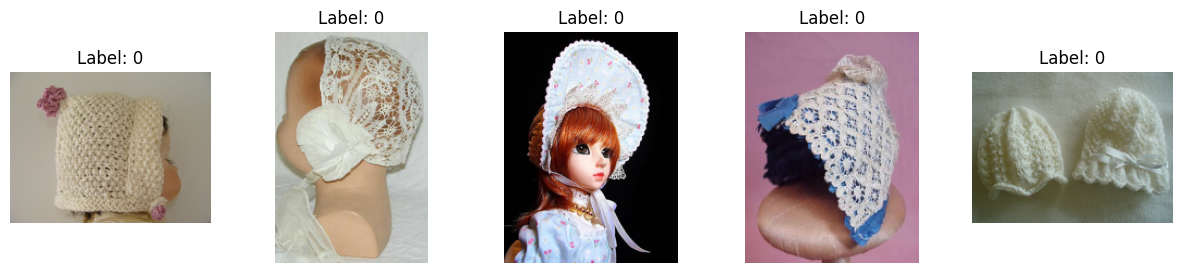

In [3]:
train_transform = get_transforms(split='train')
test_transform = get_transforms(split='test')

imagenet_train_transform = get_imagenet_transforms(split='train')
imagenet_test_transform = get_imagenet_transforms(split='test')

t_imagenet_train_transform = get_tiny_imagenet_transforms(split='train')
t_imagenet_test_transform = get_tiny_imagenet_transforms(split='test')

train_dataset = datasets.CIFAR10(
	root="./data",          
	train=True,             
	download=True,          
	transform=train_transform
)

test_dataset = datasets.CIFAR10(
	root="./data",
	train=False,
	download=True,
	transform=test_transform
)

train_loader = DataLoader(
	train_dataset,
	batch_size=batch_size,
	shuffle=True,    
	num_workers=2     
)

test_loader = DataLoader(
	test_dataset,
	batch_size=batch_size,
	shuffle=False,  
	num_workers=2
)

# load ImageNet
"""
imagenet_train_dataset = datasets.ImageFolder(
	root="./data/imagenet/imagenet/train",
    transform=imagenet_train_transform,
)

imagenet_test_dataset = datasets.ImageFolder(
	root="./data/imagenet/imagenet/train",
    transform=imagenet_test_transform
)

imagenet_train_loader = DataLoader(
	imagenet_train_dataset,
	batch_size=128,
	shuffle=True,         
)

imagenet_test_loader = DataLoader(
	imagenet_test_dataset,
	batch_size=128,
	shuffle=False,     
)
"""

# load tiny-imagenet
t_imagenet_data = load_dataset("clane9/imagenet-100")

train_t_imagenet_data = t_imagenet_data["train"]
val_t_imagenet_data = t_imagenet_data["validation"]
print(train_t_imagenet_data['image'])
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
	img = train_t_imagenet_data[i]['image']
	axs[i].imshow(img)
	axs[i].axis('off')
	axs[i].set_title(f"Label: {train_t_imagenet_data[i]['label']}")
plt.show()

train_t_imagenet_ds = ImgClassificationDataset(
    data = train_t_imagenet_data["image"],
    labels = train_t_imagenet_data["label"],
    transform = imagenet_train_transform
)

val_t_imagenet_ds = ImgClassificationDataset(
    data = val_t_imagenet_data["image"],
    labels = val_t_imagenet_data["label"],
    transform = imagenet_test_transform
)

train_t_imagenet_loader = DataLoader(
	train_t_imagenet_ds,
	batch_size=32,
	shuffle=True,
	num_workers=2
)
val_t_imagenet_loader = DataLoader(
	val_t_imagenet_ds,
	batch_size=32,
	shuffle=False,
	num_workers=2
)

# Load Tiny-ImageNet-C
"""
t_imagenet_dataset_c = ImageNetC(
	root_dir="./data/imagenet/Tiny-ImageNet-C",)

t_imagenet_loader_c = DataLoader(
	t_imagenet_dataset_c,
	batch_size=32,
	shuffle=True,
	num_workers=2
)
"""

# cifar10 loader for few-shot learning
cifar10_train_imgs, cifar10_train_labels = load_cifar10(data_dir="./data/cifar-10-batches-py", train=True, img_size=32)
cifar10_test_imgs, cifar10_test_labels = load_cifar10(data_dir="./data/cifar-10-batches-py", train=False, img_size=32)

protonet_train_dataset = FewShotDataset(data=train_t_imagenet_data["image"], labels=train_t_imagenet_data["label"], n_classes=5, n_supp=5, n_queries=10, transform=train_transform)
protonet_test_dataset = FewShotDataset(data=val_t_imagenet_data["image"], labels=val_t_imagenet_data["label"], n_classes=5, n_supp=5, n_queries=10, transform=train_transform)

protonet_train_loader = DataLoader(protonet_train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
protonet_test_loader = DataLoader(protonet_test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

## 2) Create model

In [4]:
# (1) Plain ResNet-50 (no self-correction)

model_plain = ResNet50(
	num_classes=num_classes,
	use_adabn=False,
	use_cbam=False,
	use_proto=False,
    use_rbn=False,
).to(device)


# (2) ResNet-50 + AdaBN
model_adabn = ResNet50(
	num_classes=num_classes,
	use_adabn=True,
	use_cbam=False,
	use_proto=False,
	use_rbn=False,
).to(device)

# (3) ResNet-50 + CBAM
model_cbam = ResNet50(
	num_classes=num_classes,
	use_adabn=False,
	use_cbam=True,
	use_proto=False,
    use_rbn=False,
).to(device)

# (4) ResNet-50 + Prototype Alignment
model_proto = ResNet50(
	num_classes=num_classes,
	use_adabn=False,
	use_cbam=False,
	use_proto=True,
    use_rbn=False,
).to(device)

print(f"Plain ResNet-50: {model_plain}")
print(f"ResNet-50 with AdaBN: {model_adabn}")
print(f"ResNet-50 with CBAM: {model_cbam}")
print(f"ResNet-50 with Prototype Alignment: {model_proto}")
"""
model_resnet18 = ResNet18(num_classes=10).to(device)
model_resnet50 = ResNet50(num_classes=10).to(device)
model_filmnet18_sgc = FiLMNet18_SGC(c_dim=512, num_classes=num_classes).to(device)
model_filmnet50_sgc = FiLMNet50_SGC(c_dim=512, num_classes=1000).to(device)
model_protonet18 = ProtoNet18(ResNet18, embedding_dim=512, num_classes=num_classes).to(device)
model_protonet50 = ProtoNet18(ResNet50, embedding_dim=2048, num_classes=num_classes).to(device)
print(model_resnet18)
"""


Plain ResNet-50: ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ModifiedResNet50Block(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 

'\nmodel_resnet18 = ResNet18(num_classes=10).to(device)\nmodel_resnet50 = ResNet50(num_classes=10).to(device)\nmodel_filmnet18_sgc = FiLMNet18_SGC(c_dim=512, num_classes=num_classes).to(device)\nmodel_filmnet50_sgc = FiLMNet50_SGC(c_dim=512, num_classes=1000).to(device)\nmodel_protonet18 = ProtoNet18(ResNet18, embedding_dim=512, num_classes=num_classes).to(device)\nmodel_protonet50 = ProtoNet18(ResNet50, embedding_dim=2048, num_classes=num_classes).to(device)\nprint(model_resnet18)\n'

### 2.1) Model optimizers

In [5]:

criterion = nn.CrossEntropyLoss()

#optim_resnet18  = optim.AdamW(model_resnet18.parameters(), lr=lr, weight_decay=5e-4)
#optim_resnet50  = optim.AdamW(model_resnet50.parameters(), lr=lr, weight_decay=5e-4)
#optim_protonet18 = optim.AdamW(model_protonet18.parameters(), lr=lr, weight_decay=5e-4)
#optim_filmnet18_sgc = optim.AdamW(model_filmnet18_sgc.parameters(), lr=lr, weight_decay=5e-4)
#optim_filmnet50_sgc = optim.AdamW(model_filmnet50_sgc.parameters(), lr=lr, weight_decay=5e-4)
optim_plain  = optim.SGD(model_plain.parameters(),  lr=lr, momentum=0.9, weight_decay=5e-4)
optim_adabn  = optim.SGD(model_adabn.parameters(),  lr=lr, momentum=0.9, weight_decay=5e-4)
optim_cbam   = optim.SGD(model_cbam.parameters(),   lr=lr, momentum=0.9, weight_decay=5e-4)
optim_proto  = optim.SGD(model_proto.parameters(),  lr=lr, momentum=0.9, weight_decay=5e-4)

# A dictionary to store (model, optimizer) pairs for easy looping:
baseline_dict = {
#    "ResNet18": (model_resnet18, optim_resnet18),
#    "ResNet50": (model_resnet50, optim_resnet50),
#	"ProtoNet18": (model_protonet18, optim_protonet18),
#	"Proto"   : (model_proto, optim_proto),
#	"Plain"   : (model_plain, optim_plain),
	"AdaBN"   : (model_adabn, optim_adabn),
	"CBAM"    : (model_cbam,  optim_cbam ),
}

## 3) Train model

In [6]:



# Track best validation accuracy for each baseline:
best_val_acc = {name: 0.0 for name in baseline_dict.keys()}

for name, (model, optim) in baseline_dict.items():
	train_model(name=name, model=model, optimizer=optim, train_loader=train_t_imagenet_loader, test_loader=val_t_imagenet_loader, 
				criterion=criterion, device=device, num_epochs=num_epochs)


#train_protonet(name="ProtoNet", model=model_protonet18, optimizer=optim_protonet18, train_loader=protonet_train_loader, test_loader=protonet_test_loader,
#			criterion=criterion, device=device, num_epochs=num_epochs)

#train_model(name="FilmNet50_SGC", model=model_filmnet50_sgc, optimizer=optim_filmnet50_sgc, train_loader=train_t_imagenet_loader, test_loader=val_t_imagenet_loader,
#			criterion=criterion, device=device, num_epochs=num_epochs)




=== Training baseline: AdaBN ===



KeyboardInterrupt: 

### Save the models to disk

In [ ]:
"""

# Dictionary mapping a human‐readable name → the actual nn.Module
models_to_save = {
	"plain":  model_plain,
	"adabn":  model_adabn,
	"cbam":   model_cbam,
	"proto":  model_proto,
}

# Ensure the directory exists (in this case, we’re saving to the current working directory)
save_dir = os.getcwd()
print(f"Saving models into: {save_dir}")

for name, model in models_to_save.items():
	# Construct a filename like "model_plain.pth" or "model_adabn.pth"
	filename = f"model_{name}.pth"
	filepath = os.path.join(save_dir, filename)

	# Save only the model’s state dict (weights + buffers)
	torch.save(model.state_dict(), filepath)
	print(f"→ Saved {name} to {filename}")
"""

'\n\n# Dictionary mapping a human‐readable name → the actual nn.Module\nmodels_to_save = {\n\t"plain":  model_plain,\n\t"adabn":  model_adabn,\n\t"cbam":   model_cbam,\n\t"proto":  model_proto,\n}\n\n# Ensure the directory exists (in this case, we’re saving to the current working directory)\nsave_dir = os.getcwd()\nprint(f"Saving models into: {save_dir}")\n\nfor name, model in models_to_save.items():\n\t# Construct a filename like "model_plain.pth" or "model_adabn.pth"\n\tfilename = f"model_{name}.pth"\n\tfilepath = os.path.join(save_dir, filename)\n\n\t# Save only the model’s state dict (weights + buffers)\n\ttorch.save(model.state_dict(), filepath)\n\tprint(f"→ Saved {name} to {filename}")\n'

### Load models from disk

In [ ]:
"""
# Directory to save the models
save_dir = os.getcwd()  # Current working directory


for name, (model, optim) in baseline_dict.items():
	path = os.path.join(save_dir, f"model_{name}.pth")
	if os.path.exists(path):
		state_dict = torch.load(path, map_location=device)
		model.load_state_dict(state_dict)
		print(f"Loaded {name} model from {path}")
	else:
		print(f"File not found: {path}")
"""

Loaded Proto model from /Users/codiri/University/Edinburgh/Lightweight-SCNNs/model_Proto.pth
Loaded Plain model from /Users/codiri/University/Edinburgh/Lightweight-SCNNs/model_Plain.pth
Loaded AdaBN model from /Users/codiri/University/Edinburgh/Lightweight-SCNNs/model_AdaBN.pth
Loaded CBAM model from /Users/codiri/University/Edinburgh/Lightweight-SCNNs/model_CBAM.pth


## 4) Evaluate model on CIFAR-10C dataset

In [ ]:
severity = 1  # Severity level (1-5), where 1 is the least severe
batch_size = 256

# We'll store per-model, per-corruption accuracies here:
results = { name: [] for name in baseline_dict.keys() }

# For each corruption type, build a CIFAR10C loader and measure accuracy:
for corruption in corruptions:
	# Create the CIFAR-10-C dataset for this corruption & severity
	print(f"\nEvaluating corruption: {corruption} (severity={severity})")
	ds_c = CIFAR10C(
		data_dir=CIFAR10C_ROOT,
		corruption=corruption,
		severity=severity,
		transform=test_transform
	)
	loader_c = DataLoader(ds_c,
						  batch_size=batch_size,
						  shuffle=False,
						  num_workers=2,
						  pin_memory=True)

	# For each model, run inference on this loader and compute accuracy
	for name, (model, optim) in baseline_dict.items():
		#print(f"  Evaluating {name}...", end='\n')
		model.eval()  # Set model to evaluation mode
		correct = 0
		total = 0

		with torch.no_grad():
			for images, labels in loader_c:
				images = images.to(device)
				labels = labels.to(device)

				outputs = model(images)               # (B, 10)
				_, preds = outputs.max(dim=1)         # (B,)
				correct += (preds == labels).sum().item()
				total += labels.size(0)
				#print(f"  {name}: {correct}/{total} ({100 * correct / total:.2f}%)", end='\r')

		acc = correct / total
		results[name].append(acc)

	print(f"Corruption = {corruption:<15} | "
		  + "  ".join([f"{n}: {results[n][-1]*100:5.2f}%" for n in baseline_dict.keys()]) )

# 5) Summarize average across all corruptions
# ─────────────────────────────────────────────────────────────────────────────

print("\nAverage accuracy over all 15 corruptions (severity=1):")
for name in baseline_dict.keys():
	avg_acc = np.mean(results[name])
	print(f"  {name:<5}  →  {avg_acc*100:5.2f}%")


Evaluating corruption: gaussian_noise (severity=1)


/Users/codiri/installs/miniconda3/envs/SCNN/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Corruption = gaussian_noise  | Proto: 83.88%  Plain: 82.12%  AdaBN: 83.18%  CBAM: 72.01%

Evaluating corruption: shot_noise (severity=1)
Corruption = shot_noise      | Proto: 86.41%  Plain: 85.57%  AdaBN: 84.61%  CBAM: 79.24%

Evaluating corruption: impulse_noise (severity=1)
Corruption = impulse_noise   | Proto: 87.24%  Plain: 87.74%  AdaBN: 87.14%  CBAM: 87.12%

Evaluating corruption: defocus_blur (severity=1)
Corruption = defocus_blur    | Proto: 88.88%  Plain: 88.83%  AdaBN: 87.99%  CBAM: 87.73%

Evaluating corruption: glass_blur (severity=1)
Corruption = glass_blur      | Proto: 74.55%  Plain: 73.23%  AdaBN: 77.12%  CBAM: 66.27%

Evaluating corruption: motion_blur (severity=1)
Corruption = motion_blur     | Proto: 86.97%  Plain: 85.62%  AdaBN: 86.77%  CBAM: 79.99%

Evaluating corruption: zoom_blur (severity=1)
Corruption = zoom_blur       | Proto: 84.38%  Plain: 82.98%  AdaBN: 86.37%  CBAM: 77.85%

Evaluating corruption: snow (severity=1)
Corruption = snow            | Proto: 86.6

### 4.1) Load concatenated CIFAR-10C dataset

In [ ]:
# Load and inspect CIFAR-10-C corruption arrays
print("Loading CIFAR-10-C corruption arrays...")
arr = []


for corruption in corruptions:
	arr_c = np.load(os.path.join(CIFAR10C_ROOT, f"{corruption}.npy"))
	print(f"Corruption: {corruption}, shape: {arr_c.shape}, dtype: {arr_c.dtype}")

	# concatanate all corruption arrays into a single tensor
	arr.append(arr_c)

arr = np.concatenate(arr, axis=0)
print(f"Concatenated array shape: {arr.shape}, dtype: {arr.dtype}")

labels = np.load(os.path.join(CIFAR10C_ROOT, "labels.npy"))
print(f"Labels shape: {labels.shape}, dtype: {labels.dtype}")
all_labels = np.concatenate([labels] * len(corruptions), axis=0)
print(f"All labels shape: {all_labels.shape}, dtype: {all_labels.dtype}")

# Create a daatset from the concatenated array
ds_cifar10c = ImgClassificationDataset(
	data=arr,
	labels=all_labels,
	transform=test_transform
)

# Create a DataLoader for the CIFAR-10-C dataset
loader_cifar10c = DataLoader(
	ds_cifar10c,
	batch_size=batch_size,
	shuffle=False,
	num_workers=2
)

Loading CIFAR-10-C corruption arrays...
Corruption: gaussian_noise, shape: (50000, 32, 32, 3), dtype: uint8
Corruption: shot_noise, shape: (50000, 32, 32, 3), dtype: uint8
Corruption: impulse_noise, shape: (50000, 32, 32, 3), dtype: uint8
Corruption: defocus_blur, shape: (50000, 32, 32, 3), dtype: uint8
Corruption: glass_blur, shape: (50000, 32, 32, 3), dtype: uint8
Corruption: motion_blur, shape: (50000, 32, 32, 3), dtype: uint8
Corruption: zoom_blur, shape: (50000, 32, 32, 3), dtype: uint8
Corruption: snow, shape: (50000, 32, 32, 3), dtype: uint8
Corruption: frost, shape: (50000, 32, 32, 3), dtype: uint8
Corruption: fog, shape: (50000, 32, 32, 3), dtype: uint8
Corruption: brightness, shape: (50000, 32, 32, 3), dtype: uint8
Corruption: contrast, shape: (50000, 32, 32, 3), dtype: uint8
Corruption: elastic_transform, shape: (50000, 32, 32, 3), dtype: uint8
Corruption: pixelate, shape: (50000, 32, 32, 3), dtype: uint8
Corruption: jpeg_compression, shape: (50000, 32, 32, 3), dtype: uint8


### 4.2) Compute ECE over entire CIFAR-10-C dataset

In [ ]:
# compute accuracy and ECE for each model on the CIFAR-10-C dataset
acc_list = []
ece_list = []

for name, (model, optim) in baseline_dict.items():
	print(f"\nEvaluating {name} on CIFAR-10-C dataset...")
	ece, acc = evaluate_model(model=model,
				   loader=loader_cifar10c,
				   device=device)
	acc_list.append(acc)
	ece_list.append(ece)
	print(f"{name} - Accuracy: {acc*100:.2f}%, ECE: {ece:.4f}")

	


Evaluating Proto on CIFAR-10-C dataset...
Processed 515680 / 750000 images
ECE over CIFAR-10-C: 4.99%
Accuracy over CIFAR-10-C: 79.99%
Proto - Accuracy: 79.99%, ECE: 0.0499

Evaluating Plain on CIFAR-10-C dataset...
Processed 515680 / 750000 images
ECE over CIFAR-10-C: 10.21%
Accuracy over CIFAR-10-C: 76.07%
Plain - Accuracy: 76.07%, ECE: 0.1021

Evaluating AdaBN on CIFAR-10-C dataset...
Processed 515680 / 750000 images
ECE over CIFAR-10-C: 5.40%
Accuracy over CIFAR-10-C: 81.75%
AdaBN - Accuracy: 81.75%, ECE: 0.0540

Evaluating CBAM on CIFAR-10-C dataset...
Processed 515680 / 750000 images
ECE over CIFAR-10-C: 15.18%
Accuracy over CIFAR-10-C: 70.39%
CBAM - Accuracy: 70.39%, ECE: 0.1518
